<a href="https://colab.research.google.com/github/rchicangana/AnalisisDatosProyecto/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESTADO DEL ARTE

- La imposibilidad de almacenar la energía eléctrica hace de la predicción una herramienta indispensable a la hora de gestionar eficientemente su producción. La modelización de la
demanda de energía eléctrica permite al ente productor contar con un conocimiento más refinado de los mercados y de los usuarios del sistema, así como con una mejor posición mediante la reducción de la incertidumbre en la toma de decisiones.  

- Se consultaron las Bases de Datos SciELO (Scientific Electronic Library Online) y RedAlyc (Red de Revistas Científicas de América Latina y el Caribe, España y Portugal), EBSCO, Springer Link, IEEE Xplorer y Google Académico.

- Para medir la relevancia y pertinencia de los documentos se tomaron como indicadores: que los artículos presentaran las técnicas utilizadas basadas en Inteligencia Artificial, así como metodologías y estudios de casos concretos dentro de las áreas que abarca la ingeniería eléctrica.

- Destacan dentro de las áreas de impacto la predicción de la producción y consumo eléctrico, lo cual se refiere a estudios realizados para establecer valores futuros del consumo eléctrico de una edificación particular, un complejo habitacional, industrial o incluso una ciudad o país completos. Como se indicó previamente, la adecuada predicción de estos datos es de gran importancia para planificar las fuentes de energía eléctrica y los costos asociados para los consumidores.

- La inteligencia artificial ofrece en la actualidad una diversidad de técnicas para la predicción de variables. Es la presencia de estas técnicas, en la forma de algoritmos implementados, que permiten relacionar las publicaciones con la inteligencia artificial. La diversidad de opciones de algoritmos generados se refleja en los artículos analizados
Las redes neuronales artificiales y las máquinas de vectores de soporte son las predominantes entre todas las utilizadas. Es importante destacar que es una práctica común la utilización de más de una técnica en un estudio de predicción, para realizar comparaciones y proponer la adopción de aquella técnica que haya dado mejores resultados. En la categoría de Otros se encuentran técnicas como Gradient Boosting y Modelos de Markov.

Los articulos mas citados en la publicaciones fueron

| Autores                                                       | Título del   artículo                                                                                                                                                                                        | Nombre de   la revista/publicación                           | Año  | Cantidad de citas |
|---------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------|------|-------------------|
| Gonzalez,   P. A., y Zamarreno, J. M..                        | Prediction of hourly energy   consumption in buildings based on a feedback artificial neural network                                                                                                         | Energy and buildings                                         | 2005 | 392               |
| Jain,   R. K., Smith, K. M., Culligan, P. J., y Taylor, J. E. | Forecasting energy consumption   of multi-family residential buildings using support vector regression:   Investigating the impact of temporal and spatial monitoring granularity on   performance accuracy. | Applied Energy                                               | 2014 | 379               |
| Sharma,   N., Sharma, P., Irwin, D., y Shenoy, P.             | Predicting solar generation from   weather forecasts using machine learning.                                                                                                                                 | IEEE international conference on   smart grid communications | 2011 | 370               |
| Yang,   J., Rivard, H., y Zmeureanu, R.                       | On-line building energy   prediction using adaptive artificial neural networks.                                                                                                                              | Energy and buildings,                                        | 2005 | 368               |
| Ekici,   B. B., y Aksoy, U. T.                                | Prediction of building energy   consumption by using artificial neural networks.                                                                                                                             | Advances in Engineering   Software.                          | 2009 | 358               |
| Mocanu,   E., Nguyen, P. H., Gibescu, M., y Kling, W. L.      | Deep learning for estimating   building energy consumption.                                                                                                                                                  | Sustainable Energy, Grids and   Networks.                    | 2016 | 342               |
| Edwards,   R. E., New, J., y Parker, L. E.                    | Predicting future hourly   residential electrical consumption: A machine learning case study.                                                                                                                | Energy and Buildings.                                        | 2012 | 275               |
| Ahmad,   M. W., Mourshed, M., y Rezgui, Y.                    | Trees vs Neurons: Comparison   between random forest and ANN for high-resolution prediction of building   energy consumption.                                                                                | Energy and Buildings                                         | 2017 | 263               |
| Tüfekci,   P.                                                 | Prediction of full load   electrical power output of a base load operated combined cycle power plant   using machine learning methods.                                                                       | International Journal of   Electrical Power & Energy Systems | 2014 | 241               |
| Candanedo,   L. M., Feldheim, V., y Deramaix, D.              | Bélgica                                                                                                                                                                                                      | Energy and buildings                                         | 2017 | 2                 |


-Los resultados muestran una tendencia creciente en el interés de aprovechar las posibilidades de la inteligencia artificial a la tarea de predicción de variables, y confirman la mayor representatividad de los casos en la predicción de producción y consumo energético, y en variables relacionadas con energías renovables, tales como las condiciones del viento y de energía solar. La predominancia del idioma de las publicaciones es el inglés, y en países como China, Estados Unidos y Colombia es donde se ha dado la mayor cantidad de estudios.

-Los artículos más citados en la temática tratan sobre predicción de consumo eléctrico en edificaciones particulares, y de predicción de energía solar. Las predicciones son de utilidad para labores de planificación, estimación de costos y previsión de escenarios de inversión y aprovechamiento de recursos.

-El análisis realizado en el estado del arte deja patente la actualidad y necesidad del tema de inteligencia artificial para la ingeniería eléctrica, especialmente el conocimiento de las técnicas más utilizadas para los sistemas de predicción determinadas en el presente estudio, como lo son las redes neuronales artificiales, las máquinas de vectores de soporte y los árboles de decisión. Por otra parte, el creciente interés que muestran las referencias puede interpretarse como un área de oportunidad para aprovechar las ventajas de los estudios de predicción de variables con los nuevos métodos de inteligencia artificial en lugares donde aún no se han implementado.


## Referencias:
- https://www.sciencedirect.com/science/article/pii/S2352484724007315
- https://ciencialatina.org/index.php/cienciala/article/view/2502
- https://www.revistaespacios.com/a17v38n22/a17v38n21p03.pdf
- http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S1794-12372016000200009
- https://pmc.ncbi.nlm.nih.gov/articles/PMC10948898/
- https://www.redalyc.org/pdf/462/46247652001.pdf



# 1  Introduccion

El análisis exploratorio de datos es una etapa fundamental en cualquier proyecto de Inteligencia Artificial y Ciencia de Datos, puesto que permite entender las características y patrones en los datos, así como identificar relaciones entre variables.

A continuación se presenta un estudio basado en datos de consumo de energía eléctrica horaria registrados en Cali, Colombia, junto con las temperaturas correspondientes a cada hora. El objetivo principal es explorar la relación entre estas dos variables y, posteriormente, aplicar diferentes modelos para realizar el pronósticos de corto plazo del demanda de energía.

# 2  Contexto

La demanda de energía eléctrica en una ciudad se ve inlfuenciada por muchos factores, como la temperatura, factores sociales, cronograma de produccion de grandes clientes, entre otros.

En regiones con climas variables, como es el caso de muchas ciudades Colombianas, la demanda es afectada por el uso intensivo de sistemas de refrigeración en épocas calurosas.

Los datos utilizados en este análisis incluyen mediciones horarias del consumo de energía y la temperatura registrada en la misma franja horaria, tipos de dia, mes y año. Lo que permite explorar la correlación entre estas variables.

Adicionalmente, se busca evaluar el desempeño de diferentes modelos como regresiones lineales, redes neuronales y modelos basados en árboles de decisión, para predecir el consumo de energía en un horizonte de corto plazo.

## 2.1  Descripción de los campos

- FECHA: Fecha en formato ISO de la lectura del consumo
- TEMPERATURA: Temperatura en grados Centigrados al momento de la toma del dato
- CONSUMO: Variable objetvio medido en MVA

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import holidays
#import tensorflow as tf 
#from tensorflow import keras

df = pd.read_csv('Data/datasetEmcali.csv')

print("primeras filas \n")
print(df.head())



print("se describen las columnas \n")
print(df.info())

print("dimensiones \n")
print(df.shape)

primeras filas 

             FECHA  TEMPERATURA  CONSUMO
0  12/01/2017 0:00         27.9    409.0
1  12/01/2017 1:00         29.0    387.0
2  12/01/2017 2:00         29.1    378.0
3  12/01/2017 3:00         28.2    370.0
4  12/01/2017 4:00         26.7    364.0
se describen las columnas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29808 entries, 0 to 29807
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        29808 non-null  object 
 1   TEMPERATURA  29616 non-null  float64
 2   CONSUMO      29520 non-null  float64
dtypes: float64(2), object(1)
memory usage: 698.8+ KB
None
dimensiones 

(29808, 3)


# 3  Análisis exploratorio


## 3.1  Análisis de estructura


Se realiza un analisis de la forma del dataset, se relacionan tipos de datos, estadisticas descriptivas y valores nulos.

Se adicionan columnas, basadas en la fecha, con la hipotesis que esto permitira al modelo entender e interpretar mejor los datos.

In [8]:
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')

df['CONSUMO'] = pd.to_numeric(df['CONSUMO'], errors='coerce')

df['TEMPERATURA'] = pd.to_numeric(df['TEMPERATURA'], errors='coerce')

df = df.dropna(subset=['FECHA']) # Elimina las filas donde 'FECHA' es NaN
                                 # final del data set, no tienen informacion


def es_festivo_colombia(fecha):
    """Verifica si una fecha es festivo en Colombia."""
    co_holidays = holidays.CO(years=fecha.year)
    return fecha in co_holidays
df['Is_holiday'] = df['FECHA'].apply(es_festivo_colombia)

# Extract numerical features from 'FECHA'
df['Year'] = df['FECHA'].dt.year
df['Month'] = df['FECHA'].dt.month
df['Day'] = df['FECHA'].dt.day
df['Hour'] = df['FECHA'].dt.hour
df['Dayofweek'] = df['FECHA'].dt.dayofweek
df['Dayofyear'] = df['FECHA'].dt.dayofyear
df['Weekofyear'] = df['FECHA'].dt.isocalendar().week
df['Is_month_end'] = df['FECHA'].dt.is_month_end
df['Is_month_start'] = df['FECHA'].dt.is_month_start
df['Is_quarter_end'] = df['FECHA'].dt.is_quarter_end
df['Is_quarter_start'] = df['FECHA'].dt.is_quarter_start
df['Is_year_end'] = df['FECHA'].dt.is_year_end
df['Is_year_start'] = df['FECHA'].dt.is_year_start

# Convert categorical columns to categorical
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Forma de lo datos:", df.shape)
print("\nTipo de datos por columnas:\n\n", df.dtypes)
print("\nEstadisticas descriptivas:\n\n", df.describe())
print("\nValores Faltantes:\n\n", df.isnull().sum())
print("\nValores Faltantes(%):\n\n", (df.isnull().sum() / len(df)) * 100)

Forma de lo datos: (11808, 17)

Tipo de datos por columnas:

 FECHA               datetime64[ns]
TEMPERATURA                float64
CONSUMO                    float64
Is_holiday                    bool
Year                      category
Month                     category
Day                       category
Hour                      category
Dayofweek                 category
Dayofyear                 category
Weekofyear                category
Is_month_end                  bool
Is_month_start                bool
Is_quarter_end                bool
Is_quarter_start              bool
Is_year_end                   bool
Is_year_start                 bool
dtype: object

Estadisticas descriptivas:

                                FECHA   TEMPERATURA       CONSUMO
count                          11808  11731.000000  11808.000000
mean   2019-08-07 11:12:26.341463552     24.211816    453.493681
min              2017-12-01 00:00:00     16.100000    227.000000
25%              2018-10-03 23:45:00   

se notan valores nulos

## 3.2  Análisis de variables numericas y continuas


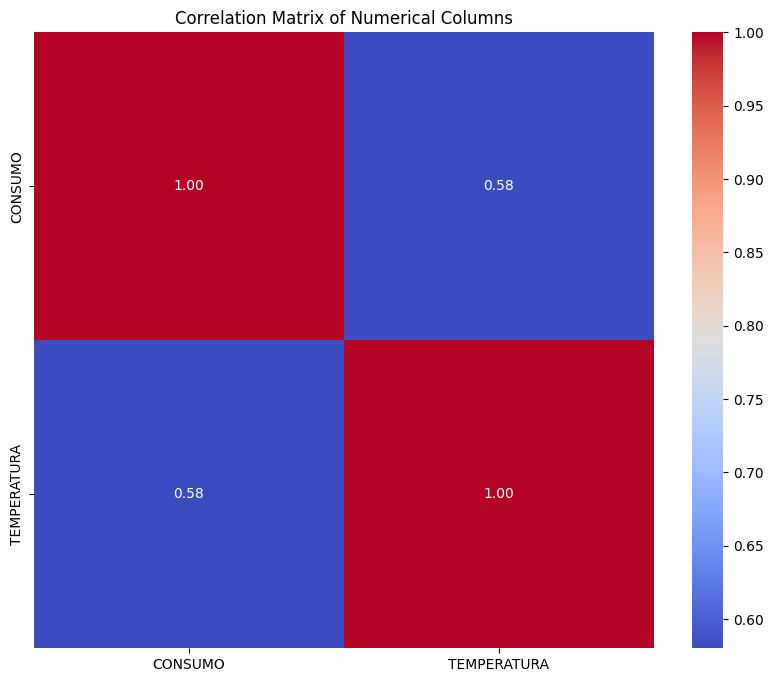

Correlation between TEMPERATURA and CONSUMO: 0.580130201586479
Correlation between CONSUMO and CONSUMO: 1.0


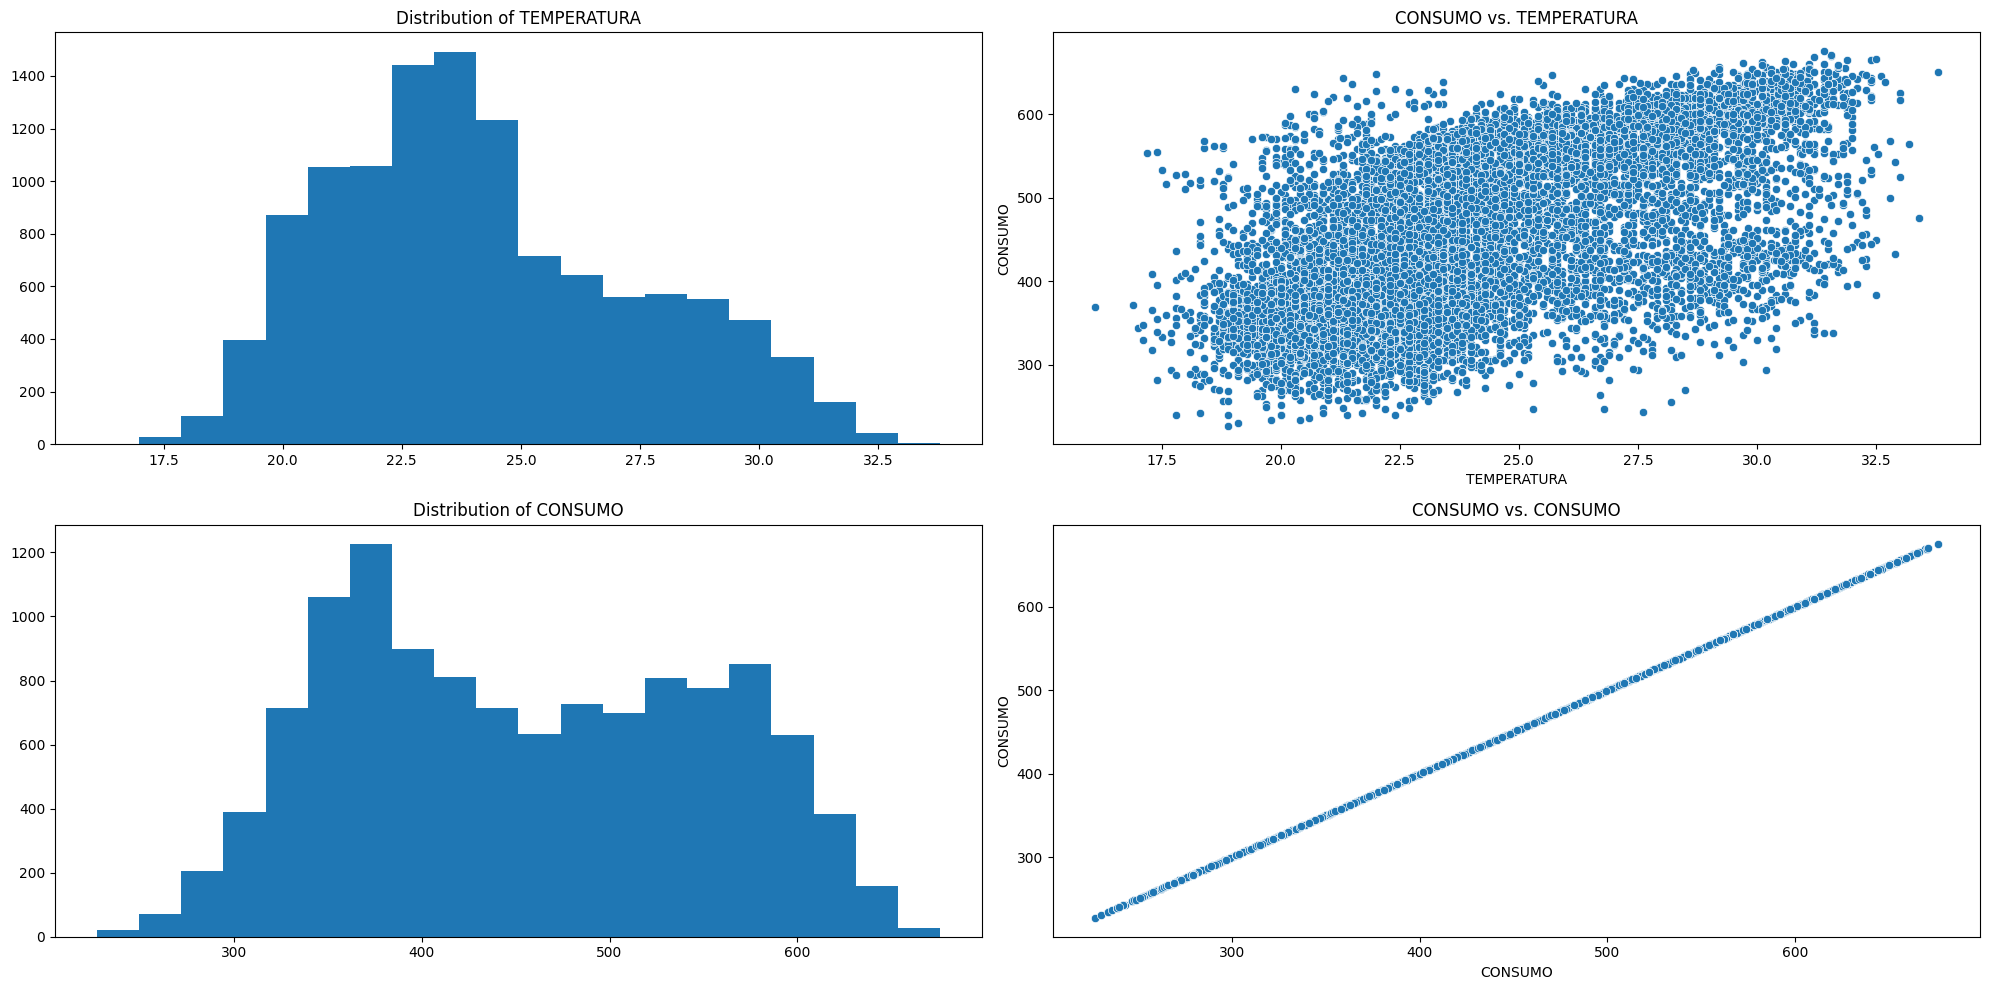

In [9]:
numerical_columns = ['CONSUMO', 'TEMPERATURA']

correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix of Numerical Columns')

plt.show()

continuous_cols = ['TEMPERATURA', 'CONSUMO']

num_cols = 2  # columns per row
num_rows = (len(continuous_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(continuous_cols):
    # Histogram
    axes[i * 2].hist(df[col], bins=20)
    axes[i * 2].set_title(f'Distribution of {col}')

    # Scatterplot
    sns.scatterplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')

    correlation = df[col].corr(df['CONSUMO'])
    print(f"Correlation between {col} and CONSUMO: {correlation}")

# Remove any unused subplots
for j in range(len(continuous_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 3.3  Análisis de variables Categoricas


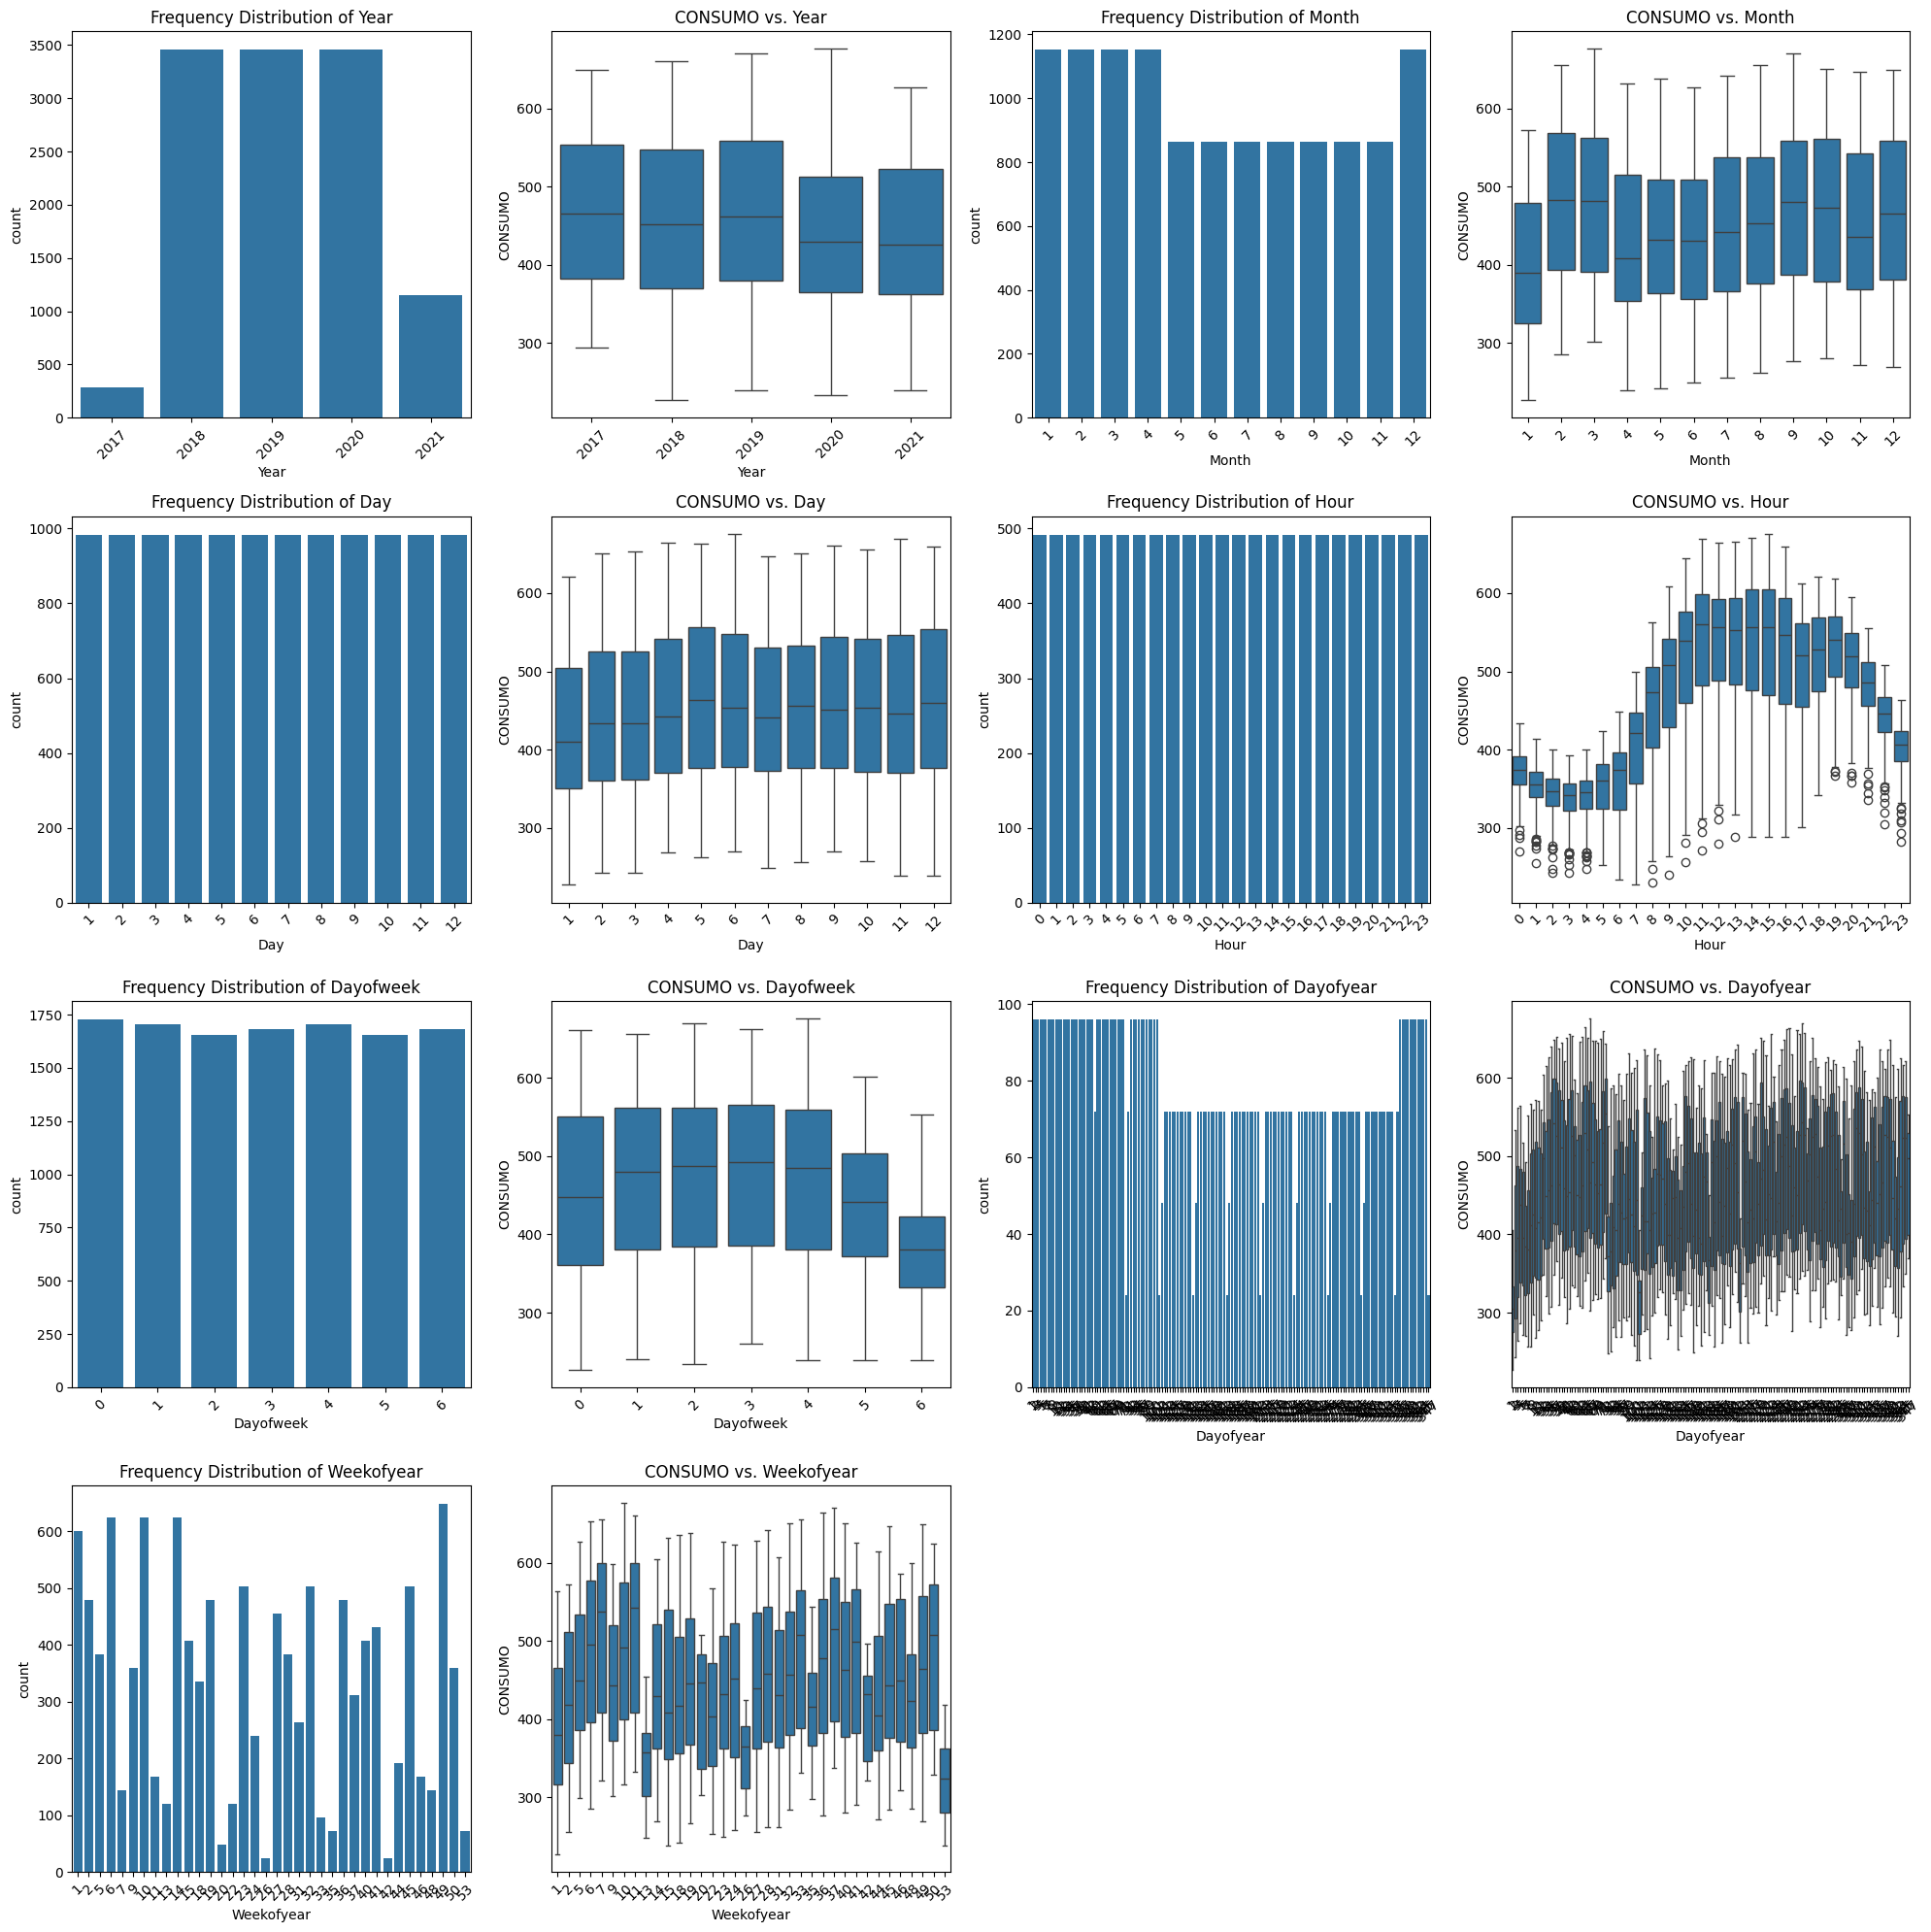

In [10]:
# Assuming 'df' is your DataFrame and 'categorical_cols' is defined
#categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']

# Determine the number of rows needed for the subplots
num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    # Countplot
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Boxplot
    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

# Remove any unused subplots
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

Los años 2020 y 2021 presentaron un fenomeno social el cual no es posible modelar en este espacio. Las restricciones a la movilidad en la pandemia y el paro nacional, impactaron directamente el consumo de eneriga en la ciudad de Cali.

Se concidera prudente, sacar del estudio estos dos años.

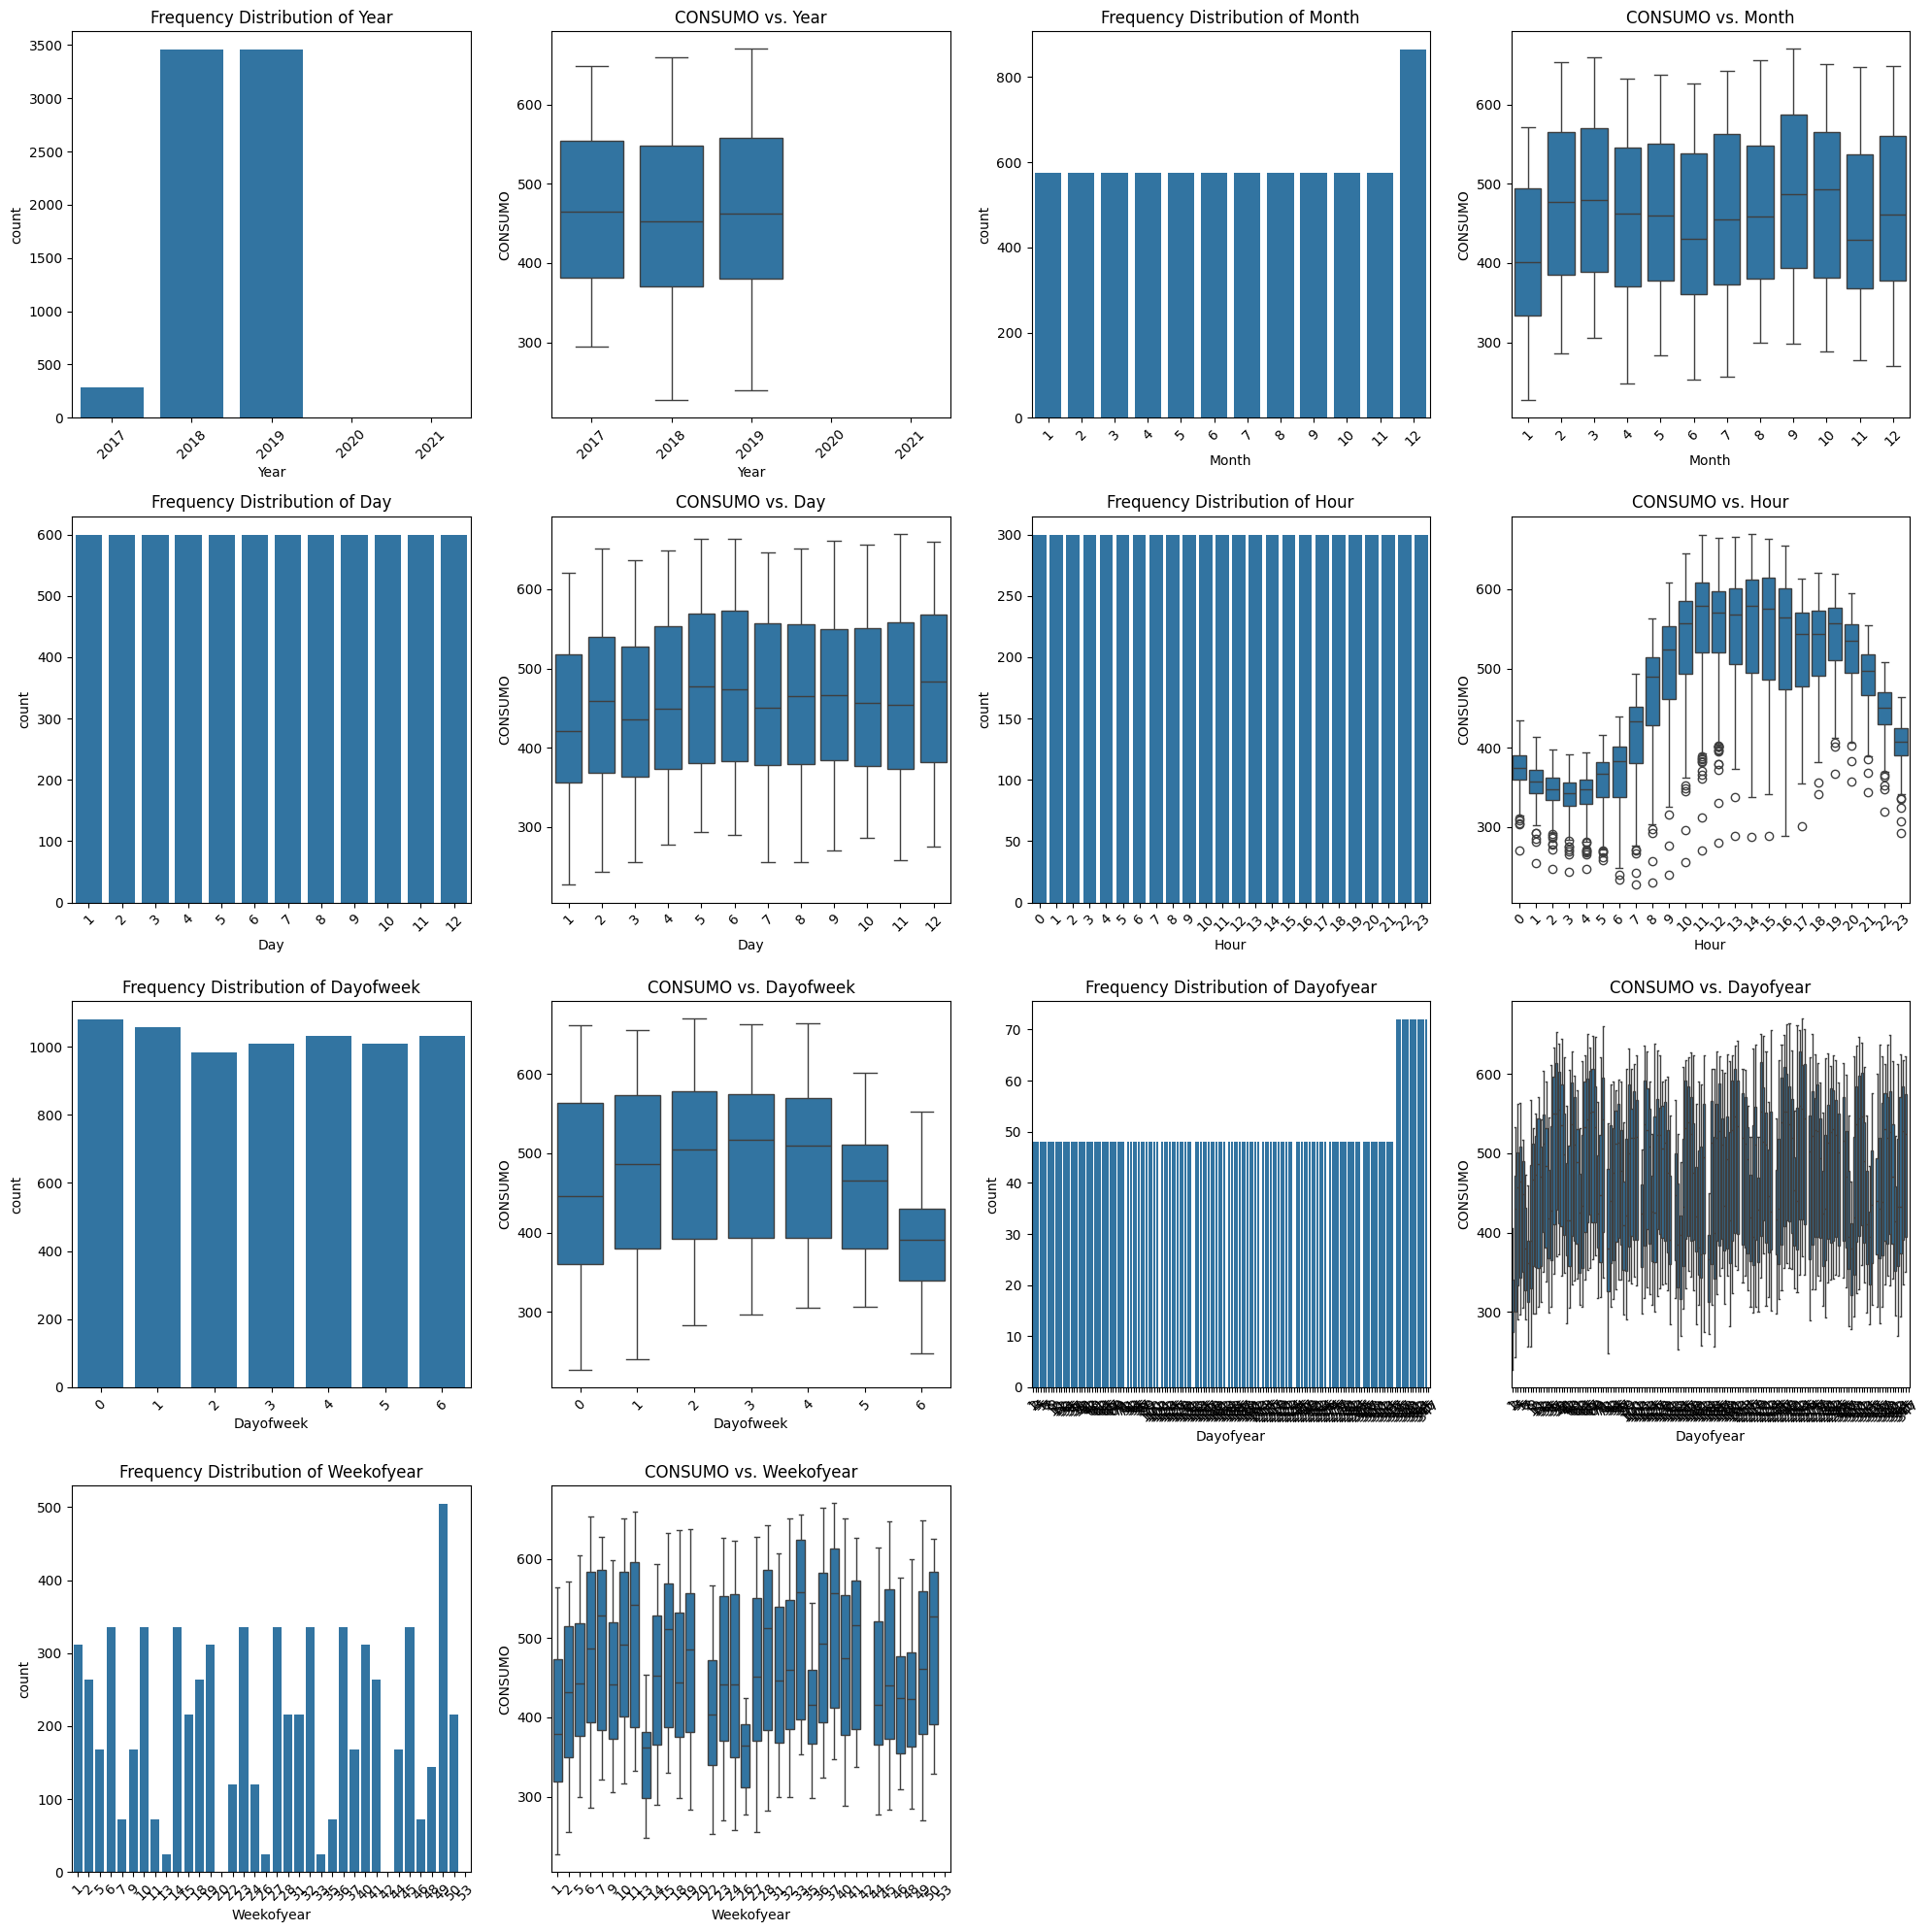

In [11]:
df = df.drop(df[(df['Year'] == 2020) | (df['Year'] == 2021)].index)
df = df.reset_index(drop=True)

num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

### 3.4.1  Analisis de outliers


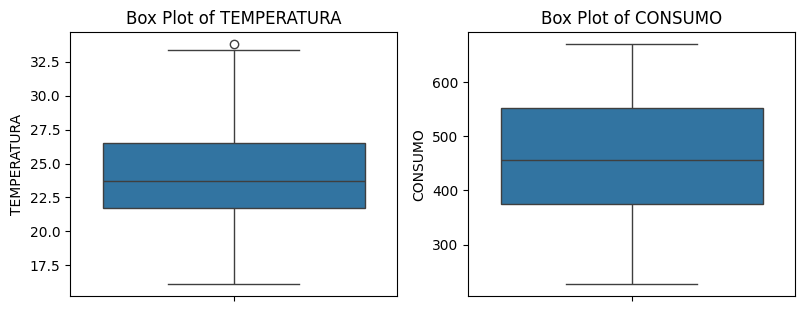


Analysis for numerical variable: TEMPERATURA
count    7200.000000
mean       24.169140
std         3.282707
min        16.100000
25%        21.700000
50%        23.700000
75%        26.500000
max        33.800000
Name: TEMPERATURA, dtype: float64
Number of outliers: 1
Lower bound: 14.499999999999998, Upper bound: 33.7
Potential causes for outliers in 'TEMPERATURA': Sensor malfunction, extreme weather events
Consequences: Skewed temperature distributions, inaccurate consumption predictions


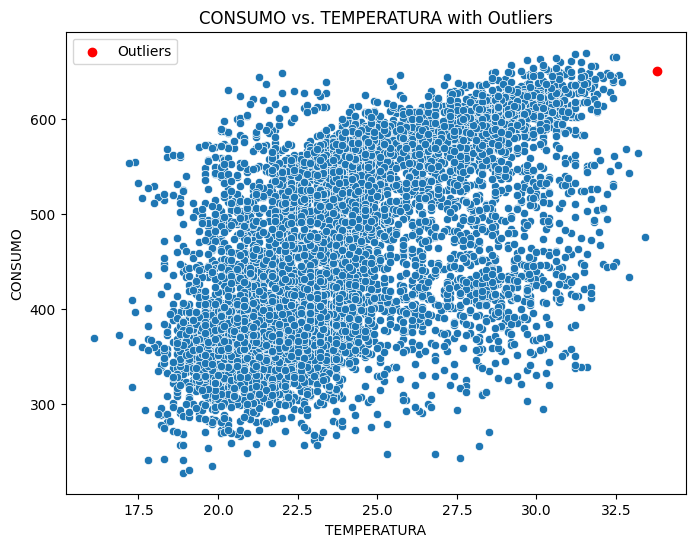


Analysis for numerical variable: CONSUMO
count    7200.000000
mean      463.074722
std        98.022407
min       227.000000
25%       375.000000
50%       457.000000
75%       553.000000
max       670.000000
Name: CONSUMO, dtype: float64
Number of outliers: 0
Lower bound: 108.0, Upper bound: 820.0


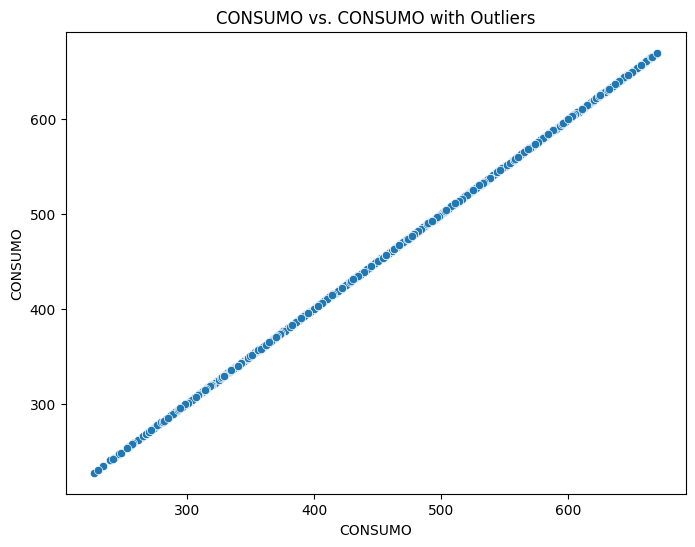

In [12]:
# Columnas numéricas
numerical_cols = ['TEMPERATURA', 'CONSUMO']
# Box plots to visualize outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Descriptive statistics and IQR outlier detection
for col in numerical_cols:
    print(f"\nAnalysis for numerical variable: {col}")
    print(df[col].describe())

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers: {len(outliers)}")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    # Document findings on potential causes and consequences of outliers (example)
    if col == 'TEMPERATURA':
        print("Potential causes for outliers in 'TEMPERATURA': Sensor malfunction, extreme weather events")
        print("Consequences: Skewed temperature distributions, inaccurate consumption predictions")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=col, y='CONSUMO', data=df)
    plt.title(f'CONSUMO vs. {col} with Outliers')

    # Highlight outliers on the scatter plot
    if not outliers.empty:
        plt.scatter(outliers[col], outliers['CONSUMO'], color='red', label='Outliers')
        plt.legend()

    plt.show()

### 3.4.2  Conclusiones Outliers


- En el contexto energetico y de negocion, los bajos consumos se puden considedar como outliers

In [13]:
df.isnull().sum()

FECHA               0
TEMPERATURA         0
CONSUMO             0
Is_holiday          0
Year                0
Month               0
Day                 0
Hour                0
Dayofweek           0
Dayofyear           0
Weekofyear          0
Is_month_end        0
Is_month_start      0
Is_quarter_end      0
Is_quarter_start    0
Is_year_end         0
Is_year_start       0
dtype: int64

# 4  Limpieza de datos


## 4.2  Imputación


In [14]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df_cleaned = df.copy()

# Crea series desplazadas para el valor anterior y siguiente
temperatura_anterior = df_cleaned['TEMPERATURA'].shift(1)
temperatura_siguiente = df_cleaned['TEMPERATURA'].shift(-1)

# Calcula el promedio del valor anterior y siguiente
promedio_anterior_siguiente = (temperatura_anterior + temperatura_siguiente) / 2

# Imputa los valores faltantes con el promedio
df_cleaned['TEMPERATURA'] = df_cleaned['TEMPERATURA'].fillna(promedio_anterior_siguiente)

# Manejar los valores NaN restantes al inicio o al final del DataFrame
df_cleaned['TEMPERATURA'] = df_cleaned['TEMPERATURA'].fillna(df_cleaned['TEMPERATURA'].median()) # Corregido

# Reassign the cleaned DataFrame to df
df = df_cleaned

print(df.head())
print(df.info())
print(df.isnull().sum())

                FECHA  TEMPERATURA  CONSUMO  Is_holiday  Year Month Day Hour  \
0 2017-12-01 00:00:00         27.9    409.0       False  2017    12   1    0   
1 2017-12-01 01:00:00         29.0    387.0       False  2017    12   1    1   
2 2017-12-01 02:00:00         29.1    378.0       False  2017    12   1    2   
3 2017-12-01 03:00:00         28.2    370.0       False  2017    12   1    3   
4 2017-12-01 04:00:00         26.7    364.0       False  2017    12   1    4   

  Dayofweek Dayofyear Weekofyear  Is_month_end  Is_month_start  \
0         4       335         48         False            True   
1         4       335         48         False            True   
2         4       335         48         False            True   
3         4       335         48         False            True   
4         4       335         48         False            True   

   Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  
0           False             False        False        

In [15]:
df= df.drop(columns=['FECHA'])

- se contempla el proceso debido a la posibilidad de la llegada de nuevos datos, a travez del cual se pueden imputan lo nuevos datos nulos. el proceso de imputacion se esat llevando a cabo teniendo en cuenta la medida anterior y posterior con referencia al dato nulo, se realiza un promedio de estas dos medidas debido a que las variaciones de la temperatura en el rango de 1 hora es minimo.
- ademas se elimina la fecha porque ya no es relevante

## 4.1  Division de datasets


In [16]:
X = df.drop(['CONSUMO'], axis=1)
y = df['CONSUMO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4.2  Estandarización y Escalamiento


Teniendo en cuenta que solo la variable temperatura es numerica y continua no se requiere Escalar o normalizar.

In [ ]:
#scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


# 5  Feature Engineering


## 5.1  Dummificar variables


In [17]:
# Use pd.get_dummies with the 'columns' parameter to specify which columns to dummify

print(X_train.head())
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Check if the number of columns in X_train and X_test are equal
print(f"Number of columns in X_train: {X_train.shape[1]}")
print(f"Number of columns in X_test: {X_test.shape[1]}")


      TEMPERATURA  Is_holiday  Year Month Day Hour Dayofweek Dayofyear  \
2034         25.1       False  2018     7   1   18         6       182   
3250         22.1       False  2018    11   4   10         6       308   
3366         20.6       False  2018    11   9    6         4       313   
1423         19.8       False  2018     4  12    7         3       102   
122          30.3       False  2017    12   6    2         2       340   

     Weekofyear  Is_month_end  Is_month_start  Is_quarter_end  \
2034         26         False            True           False   
3250         44         False           False           False   
3366         45         False           False           False   
1423         15         False           False           False   
122          49         False           False           False   

      Is_quarter_start  Is_year_end  Is_year_start  
2034              True        False          False  
3250             False        False          False  
3366 

## 5.2  PCA


In [4]:
# Split data into training and testing/validation sets
X_train_final, X_test_val, y_train_final, y_test_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

# Split testing/validation set into testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42
)

print(f"X_train_final shape: {X_train_final.shape}, y_train_final shape: {y_train_final.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


NameError: name 'X_train' is not defined

In [ ]:

# Initialize PCA with 95% variance retained
pca = PCA(n_components=0.95)

# Fit PCA on the training data
pca.fit(X_train_final)

# Transform the training, testing, and validation data
X_train_pca = pca.transform(X_train_final)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

# Print the explained variance ratio
print(pca.explained_variance_ratio_)

# Replace original data with PCA-transformed data
X_train_final = X_train_pca
X_test = X_test_pca
X_val = X_val_pca

## 5.3  LDA


## 5.4  Clustering


# 6 Data Pipeline


# 7  Modelamiento

## Modelo hibrido XGBoost + DNN

In [18]:
import xgboost as xgb
from tensorflow import keras

# 1. Define and train the DNN model
dnn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Output layer for regression
])

dnn_model.compile(optimizer='adam', loss='mse')
dnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# 2. Use the DNN model to generate predictions for the training and test sets
dnn_train_predictions = dnn_model.predict(X_train)
dnn_test_predictions = dnn_model.predict(X_test)

# 3. Combine the original features with the DNN predictions
X_train_hybrid = np.hstack((X_train, dnn_train_predictions))
X_test_hybrid = np.hstack((X_test, dnn_test_predictions))

# 4. Train the XGBoost model using the hybrid features
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=10, random_state=42)
xgb_model.fit(X_train_hybrid, y_train)

# 5. Make predictions with the XGBoost model
y_pred_hybrid = xgb_model.predict(X_test_hybrid)

# 6. Evaluate the hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
r2_hybrid = r2_score(y_test, y_pred_hybrid)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
rmse_hybrid = np.sqrt(mse_hybrid)

print(f"Hybrid Model - Mean Squared Error (MSE): {mse_hybrid}")
print(f"Hybrid Model - R-squared (R2): {r2_hybrid}")
print(f"Hybrid Model - Mean Absolute Error (MAE): {mae_hybrid}")
print(f"Hybrid Model - Root Mean Squared Error (RMSE): {rmse_hybrid}")

Epoch 1/100


c:\Users\rchic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 156721.7656 - val_loss: 5665.3726
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7827.1729 - val_loss: 4421.0522
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6460.8574 - val_loss: 3527.2749
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5328.8262 - val_loss: 2875.8835
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4726.7671 - val_loss: 2438.0908
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4214.2524 - val_loss: 2024.5000
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4218.0962 - val_loss: 1835.1334
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3732.5234 - val_loss: 1669.7928
Epoch 9/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3636.7556 - val_loss: 1614.8744
Epoch 10/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3685.2561 - val_loss: 1515.6500
Epoch 11/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3227.4529 - val_l

RegresionLineal

In [ ]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Calculate MAE and MedAE
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Randomforest

In [ ]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train_final, y_train_final)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - R-squared (R2): {r2_rf}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)

# Calculate the Median Absolute Error (MedAE)
medae = median_absolute_error(y_test, y_pred_rf)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print the calculated MAE, MedAE, and RMSE values.
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Hiperparametros

In [ ]:
# Define la cuadrícula de hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
}

# Crea un objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajusta el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train_final, y_train_final)

# Obtén el mejor modelo
best_model = grid_search.best_estimator_

# Evalúa el mejor modelo en los datos de prueba
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Imprime las métricas de evaluación
print(f"Mejor modelo - Error cuadrático medio (MSE): {mse_best}")
print(f"Mejor modelo - R-cuadrado (R2): {r2_best}")

Red neuronal

In [ ]:
# 1. Definir el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # Capa de salida para regresión
])

# 2. Compilar el modelo
model.compile(optimizer='adam', loss='mse')  # Usamos 'mse' (error cuadrático medio) para regresión

# 3. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# 4. Realizar predicciones
y_pred = model.predict(X_test)

# 5. Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

# Opcional: Graficar la pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Red neuronal con LSTM

In [ ]:
df.head()


In [ ]:
# 1. Preparar datos para LSTM (reshape a [muestras, pasos de tiempo, características])
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 2. Definir el modelo LSTM
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    keras.layers.Dense(1)
])

# 3. Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

# 4. Realizar predicciones
y_pred = model.predict(X_test_reshaped)

# 5. Evaluar el modelo
# (calcula métricas como MSE, MAE, etc.)